# OOD Detection
The purpose of this lab project is to enhance our understanding of OOD detection. After accomplishing the lab project, you should be able to:
- Code different OOD score functions and use them for OOD detection.
- Perform benchmarking experiments involving different OOD score functions and different metrics.
- Visualize OOD detection results and check for common mistakes in OOD detection experiments.

As usual, we start by importing the necessary libraries.

In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 1. Data
The ultimate purpose of this notebook is to perform a benchmarking experiment in order to compare multiple OOD scores and OOD detection algorithms. To that end, we will use three different data sets:
1. The **Cifar-10 train** dataset in order to train a simple convolutional neural network for the task of image classification.
2. The **Cifar-10 test** set as the *in-distribution* dataset (i.e. the dataset of normal examples), for evaluating the different OOD scores.
3. (A subset of) The **SVHN test** set as the *out-of-distribution* dataset (i.e. the dataset of anomalous examples), for evaluating the different OOD scores.



In [109]:
# Data loading and preprocessing
batch_size = 128

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

cifar_train = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
cifar_test = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
svhn_test = datasets.SVHN(root='./data', split='test', transform=transform, download=True)

# Extract 10_000 random images from the svhn_test set
svhn_test, _ = torch.utils.data.random_split(svhn_test, [10_000, len(svhn_test) - 10_000])

train_loader = DataLoader(cifar_train, batch_size=batch_size, shuffle=True)
cifar_test_loader = DataLoader(cifar_test, batch_size=batch_size, shuffle=False)
svhn_test_loader = DataLoader(svhn_test, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/test_32x32.mat


In [110]:
print(f"Number of training samples: {len(cifar_train)}")
print(f"Number of test samples: {len(cifar_test)}")
print(f"Number of SVHN test samples: {len(svhn_test)}")

Number of training samples: 50000
Number of test samples: 10000
Number of SVHN test samples: 10000


## 2. CNN Classifier
We will first train a CNN Classifier on the Cifar-10 training data, for the task of classifying the Cifar-10 images.

The architecture of the CNN should be:
- A convolutional layer with 32 filters, kernel size 3, stride 1 and padding 1.
- A ReLU activation
- A max pooling layer with kernel size 2.
- A convolutional layer with 64 filters, kernel size 3, stride 1 and padding 1.
- A ReLU activation
- A max pooling layer with kernel size 2.
- A fully connected layer with 128 neurons.
- A ReLU activations (the activations after this layer will be called the "features of the penultimate layer").
- A fully connected layer with 10 neurons.

This CNN will output the logit values.

**Exercise** Define a CNN having the above architecture by implementing the `__init__` and `forward` methods below. Bare in mind that some of the OOD scores we will define require access to the features of the penultimate layer.
- Add a `return_features` argument to the `forward` method, defaulting to `False`. If `return_features` is set to `True`, the `forward` method should return the features of the penultimate layer instead of the logit values.

In [111]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x, return_features=False):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        features = self.relu(self.fc1(x))
        if return_features:
            return features  # Return features before fc2
        logits = self.fc2(features)
        return logits

## 3. Training
We will train the above CNN on the Cifar-10 training set.

**Exercise.** Train the CNN:
- For 5 epochs
- Using a learning rate of 0.001
- Choose an appropriate loss function
- Using the Adam optimizer
- Print the mean loss of the epoch at the end of each epoch.
- *Optional.* You can choose to monitor the training by printing the train/test accuracy too.

In [112]:
model = SimpleCNN().to(device)

In [113]:
# Hyper-parameters
num_epochs = 5
learning_rate = 0.001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
def train_model():
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")


In [114]:
train_model()

Epoch [1/5], Loss: 1.4152
Epoch [2/5], Loss: 1.0395
Epoch [3/5], Loss: 0.8802
Epoch [4/5], Loss: 0.7778
Epoch [5/5], Loss: 0.6899


**Exercise.** Print the test loss and the test accuray after training.

In [115]:
# print test loss and accuracy
model.eval
with torch.no_grad():
    test_loss = 0
    correct = 0
    total = 0
    for images, labels in cifar_test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Test Loss: {test_loss / len(cifar_test_loader):.4f}")
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Loss: 0.8296
Test Accuracy: 71.93%


## 4. OOD Metrics
The objective of this section is to define the different OOD metrics studied during the lectures. Recall that we have seen two kinf of metrics:
1. Fixed-threshold metrics.
2. Threshold-independent metrics.

### 4.1. Fixed-threshold metrics
We will start to define the metrics for OOD detectors with a fixed threshold. The inputs to all of our metrics below will be:
- The `scores_negatives` nupy array: an array containing the scores for the ground truth negative images (i.e. the Cifar-10 test images).
- The `scores_positives` numpy array: an array containing the scores for the ground truth positive images (i.e. the SVHN test images).
- The `threshold` floating point number. The threshold value $\tau$ such that such that our OOD detector classifies examples according to their score as follwos:
$$\begin{cases}
s \leq \tau\quad &⇒\quad \text{negative}\\
s > \tau\quad &⇒\quad \text{positive}
\end{cases}$$
- Any other parameters necessary for the metric in question.

**Exercise.** Define the functions below:
1. A `confusion_matrix` function that outputs the number of *false positives*, *true positives*, *true negatives* and *false negatives*.
2. A `tpr_fpr` function that outputs the  *true positive rate* and *false positive rate*.
3. An `accuracy` function that outputs the accuracy.
4. A `precission_recall` function that outputs the *precision* and the *recall*.
5. A `f_beta` function that takes an additional input argument `beta` and returns the corresponding $F_\beta$ score.

In [116]:
# TPR and FPR

def confusion_matrix(scores_negatives, scores_positives, threshold):
    false_positives = np.sum(scores_negatives > threshold)
    true_postives = np.sum(scores_positives > threshold)
    true_negatives = np.sum(scores_negatives <= threshold)
    false_negatives = np.sum(scores_positives <= threshold)
    return false_positives, true_postives, true_negatives, false_negatives

def tpr_fpr(scores_negatives, scores_positives, threshold):
    fp, tp, tn, fn = confusion_matrix(scores_negatives, scores_positives, threshold)
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr, fpr

def accuracy(scores_negatives, scores_positives, threshold):
    fp, tp, tn, fn = confusion_matrix(scores_negatives, scores_positives, threshold)
    return (tp + tn) / (tp + tn + fp + fn)

def precision_recall(scores_negatives, scores_positives, threshold):
    fp, tp, tn, fn = confusion_matrix(scores_negatives, scores_positives, threshold)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return precision, recall

def f_beta(scores_negatives, scores_positives, threshold, beta):
    precision, recall = precision_recall(scores_negatives, scores_positives, threshold)
    return (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

### 4.2. Threshold-independent metrics
**Exercise.** Define the function `roc_auc` that:
- Takes as input the `scores_negatives` and `scores_positives` numpy arrays.
- Plots the *ROC curve*.
- Returns the value of the *AUROC* as the area under the *ROC curve*.

In [117]:
def roc_auc(scores_negatives, scores_positives):
    # Combine scores and create labels
    scores = np.concatenate((scores_negatives, scores_positives))
    labels = np.concatenate((np.zeros(len(scores_negatives)), np.ones(len(scores_positives))))

    # Sort scores and labels
    sorted_indices = np.argsort(scores)
    scores = scores[sorted_indices]
    labels = labels[sorted_indices]

    # Initialize TPR and FPR
    tpr = []
    fpr = []
    n_pos = np.sum(labels)
    n_neg = len(labels) - n_pos

    tp = n_pos
    fp = n_neg

    # Compute TPR and FPR at each threshold
    for i in range(len(scores)):
        if labels[i] == 1:  # True positive
            tp -= 1
        else:  # False positive
            fp -= 1
        tpr.append(tp / n_pos)
        fpr.append(fp / n_neg)

    tpr = np.array(tpr)
    fpr = np.array(fpr)

    # Compute AUROC (Area Under the Curve)
    auroc = - np.trapz(tpr, fpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC Curve (AUROC = {auroc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    return auroc



## 5. OOD Scores
In this section, we will implement the different OOD scores seen during the lecture. Recall that we can split the different OOD scores into two score families:
1. Logit-based scores.
2. Feature-based scores.

### 5.1. Logit-based scores
Logit-based scores are simpler to implement than feature-based scores. We will implement each of the logit-based scores as a function that takes as inputs the `logits` array of logits of the different test points,
and returns the array of test point scores.

**Exercise.** Complete the functions below with the formulas seen during the lecture.

In [118]:
# MLS Score
def mls(logits):
    scores = - torch.max(logits, dim=1)[0]
    return scores.cpu().numpy()

# MSP Score
def msp(logits):
    probas = torch.softmax(logits, dim=1)
    max_probas_scores = - torch.max(probas, dim=1)[0]
    return max_probas_scores.cpu().numpy()

# Energy Score
def energy(logits, temp=1):
    energies = - temp * torch.logsumexp(logits / temp, dim=1)
    return energies.cpu().numpy()

# Entropy Score
def entropy(logits):
    probas = torch.softmax(logits, dim=1)
    entropies = - torch.sum(probas * torch.log(probas + 1e-8), dim=1)
    return entropies.cpu().numpy()

### 5.2. DKNN
In this section we define a class `DKNN` to compute the Deep $K$-nearest neighbor score. This score is more involved than the previous ones for two main reasons:
- It employs the activations of the penultimate layer of the CNN rather than the logit or softmax values.
- It requires a fitting dataset in order to compute distances of the test images with respect to the images in the fitting dataset. We will be using the Cifar-10 training set as fitting dataset.

*Exercise.* Complete the following methods in the class `DKNN` below:
1. The `_l2_normalization` method that computes that normalizes a batch of feature vectors by dividing each feature vector by its $\ell_2$ norm.
2. The `compute_scores` function that computes the distance from each of the test points to its $k$-th nearest neighbor in the fit dataset. The distances are computed between the normalized feature representations. The test points are processed in batches to avoid memory issues.

In [119]:
class DKNN:
    def __init__(self, k=50, batch_size=256):
        self.k = k
        self.batch_size = batch_size
        self.fit_features = None

    def _l2_normalization(self, feat):
        norms = torch.norm(feat, p=2, dim=1, keepdim=True) + 1e-10  # Avoid division by zero
        return feat / norms

    def fit(self, fit_dataset):
        self.fit_features = self._l2_normalization(fit_dataset)

    def compute_scores(self, test_features):
        test_features = self._l2_normalization(test_features)
        scores = []

        # Process test features in batches
        for i in range(0, test_features.size(0), self.batch_size):
            batch = test_features[i:i + self.batch_size]
            # Compute pairwise distances for the batch
            distances = torch.cdist(batch, self.fit_features, p=2)  # (batch_size, num_fit_samples)
            # Sort distances and extract the k-th nearest
            sorted_distances, _ = torch.sort(distances, dim=1)
            scores.append(sorted_distances[:, self.k - 1])  # k-th nearest distance

        # Concatenate scores from all batches
        return torch.cat(scores, dim=0).cpu().numpy()

### 5.3. Mahalanobis
In this section we define a class `Mahalanobis` to compute the Mahalanobis score. This class is similar to the `DKNN` for the same reasons as before:
- It employs the activations of the penultimate layer of the CNN rather than the logit or softmax values.
- It requires a fitting dataset in order to compute distances of the test images with respect to the images in the fitting dataset. We will be using the Cifar-10 training set as fitting dataset.

*Exercise.* Complete the following methods in the class `Mahalanobis` below:
1. The `fit` method that fits per-class mean vectors and a common covariance matrix to the fitting dataset.
2. The `_mahalanobis_distance` method that computes the Mahalanobis distance of a given vector with respect to the gaussian law parametrized by its mean vector and covariance matrix.
3. The `compute_scores` function that uses the two previous methods to compute the Mahalanobis score of all test points by taking the maximum of Mahalanobis distances over the set of different classes/labels.

In [120]:
class Mahalanobis():
    def __init__(self):
        self.mus = None
        self.inv_cov = None
        self.labels = None

    def fit(self, features, labels):
        self.labels = np.unique(labels)
        self.mus = {}
        covs = {}
        for label in self.labels:
            label_mask  = (labels == label)
            label_features = features[label_mask]
            self.mus[label.item()] = label_features.mean(dim=0)
            covs[label.item()] = torch.cov(label_features.T) * label_features.size(0)

        cov = sum(covs.values()) / features.size(0)
        self.inv_cov = torch.linalg.pinv(cov)

    def _mahalanobis_distance(self, x, mu, inv_cov):
        diff = x - mu
        return diff @ inv_cov @ diff.T

    def compute_scores(self, test_features):
        scores = []
        for test_feature in test_features:
            distances = torch.tensor([
                self._mahalanobis_distance(test_feature, self.mus[label.item()], self.inv_cov)
                for label in self.labels
            ])
            scores.append(-torch.min(distances))
        return torch.stack(scores).cpu().numpy()

## 6. Score Comparison
The objective of this section is to compare the different OOD scores that we have just defined. Note that in order to use the *threshold-dependent metrics*, we need to pick a threshold for each of the scores.

Picking the same threshold for all scores *is not* a proper way to compare the different scores, since thy are scaled differently. A common way to perform a more "fair" comparison is to do the following:
1. Fix a target TPR, e.g. 0.9.
2. Compute the threshold $\tau$ such that the TPR on the SVHN test dataset is equal to the target TPR 0.9.
3. Compute the remaining fixed-threshold metrics for such $\tau$.

**Exercise.** Define the function `compute_threshold` that:
- Takes as inputs `scores`, a numpy array of scores and a `target_tpr`, a value between 0 and 1 defaulting to 0.95.
- Assuming that the array of `scores` contains the scores of the positive examples, the function computes and returns the value of the threshold $\tau$ that achieves the desired `target_tpr`.

In [121]:
def compute_threshold(scores, target_tpr=0.95):
    sorted_scores = np.sort(scores)
    target_index = int(np.ceil((1-target_tpr) * len(sorted_scores))) - 1

    # Handle edge cases
    target_index = max(0, target_index)  # Ensure index is non-negative
    target_index = min(len(sorted_scores) - 1, target_index)  # Ensure index is within bounds

    # Select the threshold
    threshold = sorted_scores[target_index]

    return threshold

In order to compare the different OOD scores that we have defined, we set the variable `target_tpr` equal to 0.9 and we initialise an empty dictionary to store the different metrics for the different OOD scores.

In [122]:
target_tpr = 0.9
metrics_dict = {}

### 6.1. Metrics for logit-based scores

**Exercise.** Next we compute the different evaluation metrics for each of the scores above, starting with the *logit-based scores*:
1. Extract the logits of the Cifar-10 test set and the SVHN test set.
2. For each of the *MLS*, *MSP*, *Energy (T=1)* and *Entropy* OOD score functions:
  - Compute the scores on the Cifar-10 test set and the SVHN test set.
  - Plot the histogram of the scores and check that the negative samples have, on average, lower scores than the positive samples.
  - Use the `roc_auc` function to plot the ROC curves and compute the AUROCs.
  - Compute the trhreshold that achieves 0.1 FPR and compute the fixed-threshold metrics associated to it: accuracy, TPR, Precision, Recall and $F_1$.
  - Store all the metrics in the `metrics_dict` dictionary for future comparison.

In [123]:
# Compute logits directly from the dataset
def compute_logits(dataset, model, device):
    all_logits = []
    with torch.no_grad():
        for i in range(len(dataset)):
            image, _ = dataset[i]  # Get each image directly from the dataset
            image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
            logits = model(image)
            all_logits.append(logits)
    return torch.cat(all_logits, dim=0)  # Concatenate all logits into a single tensor

# Apply the function to CIFAR-10 and SVHN datasets
test_logits_negatives = compute_logits(cifar_test, model, device)
test_logits_positives = compute_logits(svhn_test, model, device)

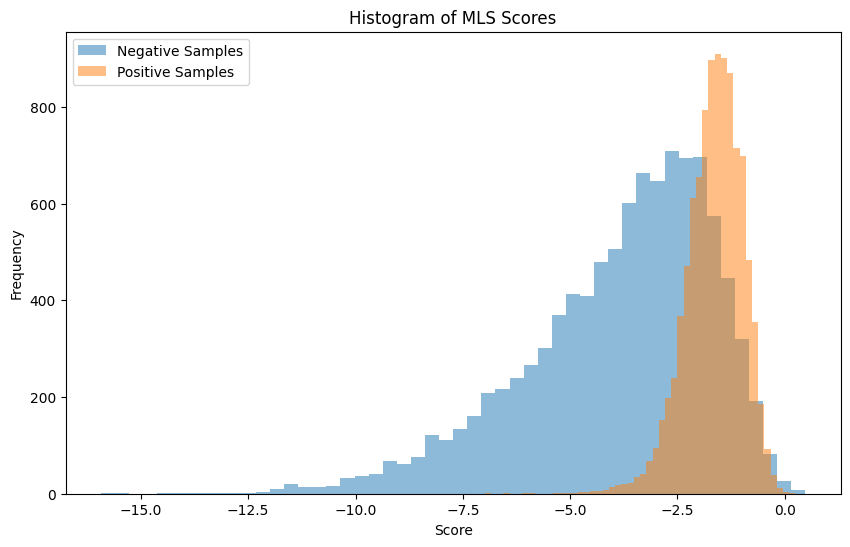

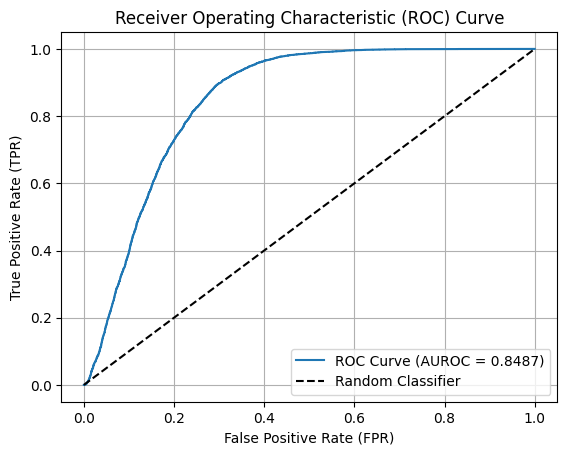

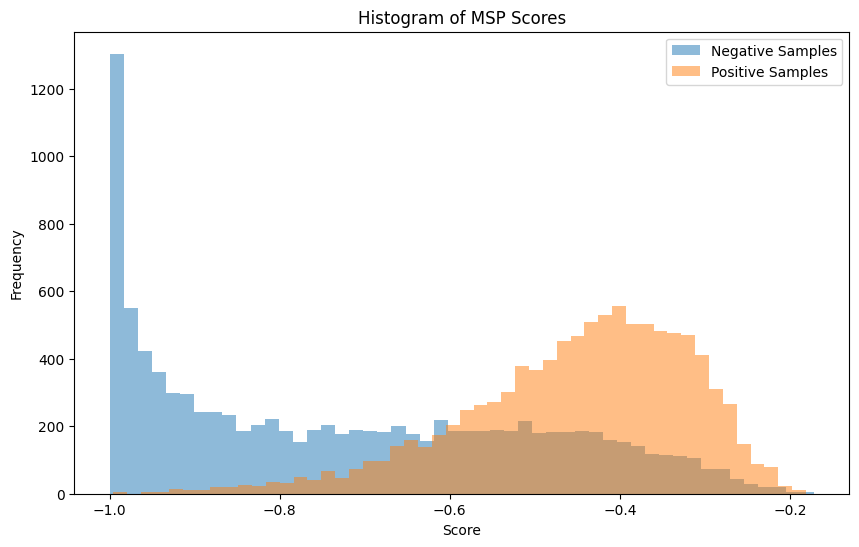

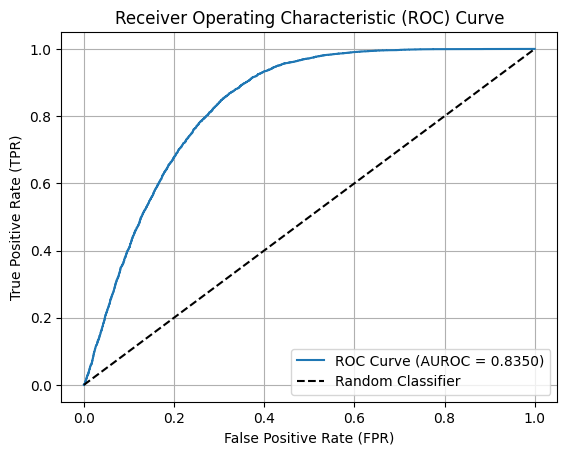

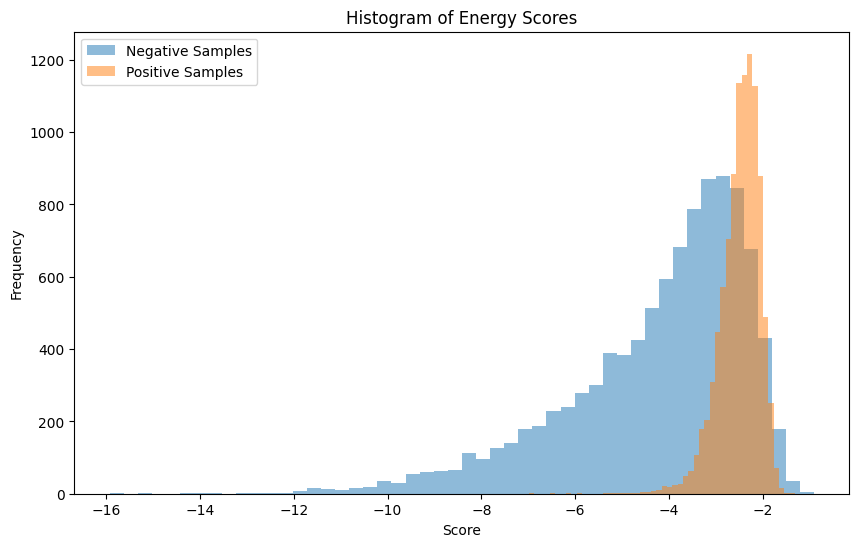

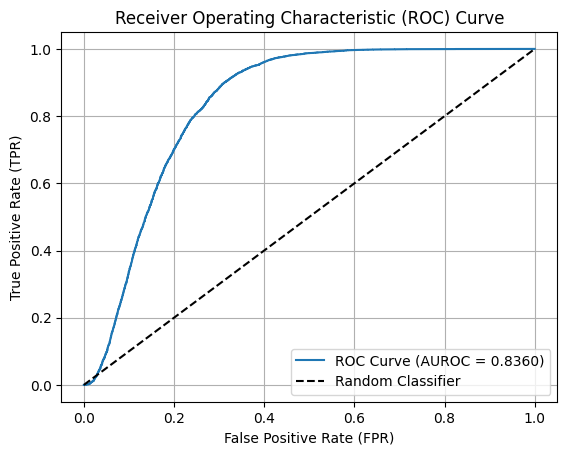

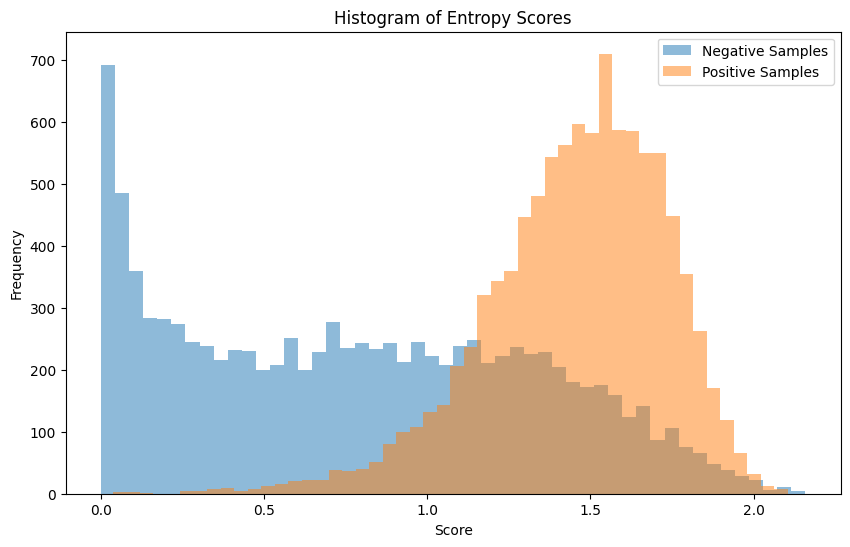

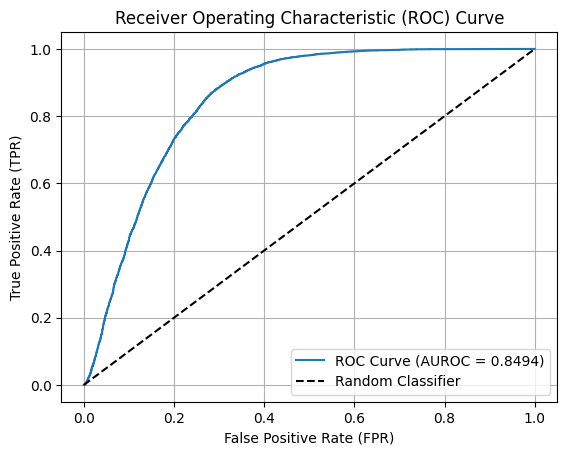

In [124]:
scoring_functions = {
    'MLS': mls,
    'MSP': msp,
    'Energy': energy,
    'Entropy': entropy
}

for method, scoring_function in scoring_functions.items():

    # Compute scores
    scores_negatives = scoring_function(test_logits_negatives)
    scores_positives = scoring_function(test_logits_positives)

    # Plot histogram of scores
    plt.figure(figsize=(10, 6))
    plt.hist(scores_negatives, bins=50, alpha=0.5, label='Negative Samples')
    plt.hist(scores_positives, bins=50, alpha=0.5, label='Positive Samples')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {method} Scores')
    plt.legend()
    plt.show()

    # Initialize empty dict for metrics
    metrics_dict[method] = {}

    # Plot ROC curve and compute AUROC
    auroc = roc_auc(scores_negatives, scores_positives)
    metrics_dict[method]['auroc'] = auroc

    # Compute threshold for the given target_tpr
    threshold = compute_threshold(scores_positives, target_tpr)

    # Compute and store remaining metrics
    metrics_dict[method]['accuray'] = accuracy(scores_negatives, scores_positives, threshold)
    metrics_dict[method]['tpr'], metrics_dict[method]['fpr'] = tpr_fpr(scores_negatives, scores_positives, threshold)
    metrics_dict[method]['precision'], metrics_dict[method]['recall'] = precision_recall(scores_negatives, scores_positives, threshold)
    metrics_dict[method]['f1'] = f_beta(scores_negatives, scores_positives, threshold, beta=1)

### 6.2. Metrics for feature-based scores

**Exercise.** Extract the representations in the feature space given by the penultimate layer of the CNN of the three datasets: Cifar-10 training dataset, Cifar-10 test set and SVHN test set.

In [125]:
# Compute features directly from the dataset
def compute_features(dataset, model, device):
    all_features = []
    with torch.no_grad():
        for i in range(len(dataset)):
            image, _ = dataset[i]  # Get each image directly from the dataset
            image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
            features = model(image, return_features=True)
            all_features.append(features)
    return torch.cat(all_features, dim=0)  # Concatenate all logits into a single tensor

# Apply the function to CIFAR-10 train, test, and SVHN test datasets
train_features = compute_features(cifar_train, model, device)
test_features_negatives = compute_features(cifar_test, model, device)
test_features_positives = compute_features(svhn_test, model, device)

**Exercise.**
1. Compute the *DKNN scores* for the Cifar-10 test dataset and the SVHN test datsets using the 5-th nearest neighbor.
2. Plot the histogram of the scores and check that the negative samples have, on average, lower scores than the positive samples.
2. Use the `roc_auc` function to plot the ROC curve and compute the AUROC.
3. Compute the trhreshold that achieves 0.1 FPR and compute the fixed-threshold metrics associated to it: accuracy, TPR, Precision, Recall and $F_1$.
4. Store all the metrics in the `metrics_dict` dictionary for future comparison.


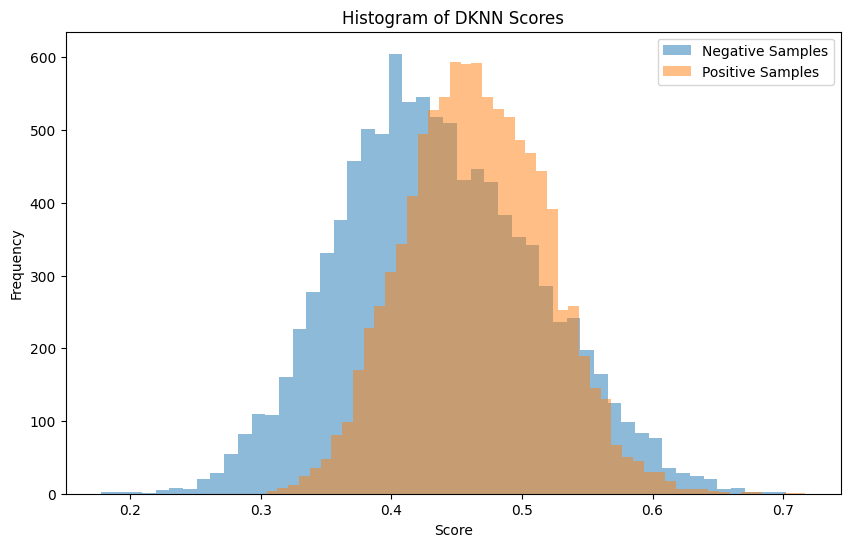

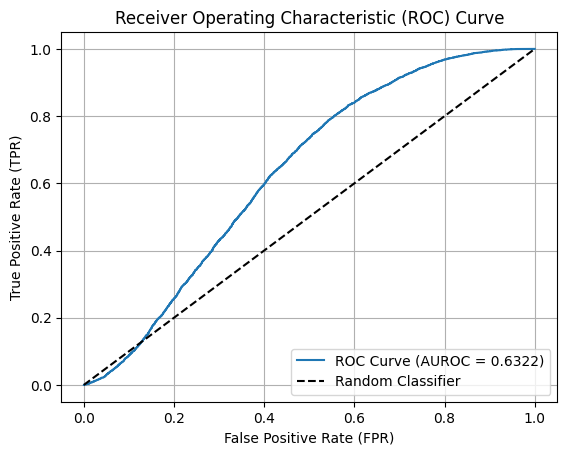

In [126]:
metrics_dict['DKNN'] = {}

dknn = DKNN(k=10)
dknn.fit(train_features)

scores_negatives = dknn.compute_scores(test_features_negatives)
scores_positives = dknn.compute_scores(test_features_positives)

# Plot the histogram of the scores
plt.figure(figsize=(10, 6))
plt.hist(scores_negatives, bins=50, alpha=0.5, label='Negative Samples')
plt.hist(scores_positives, bins=50, alpha=0.5, label='Positive Samples')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title(f'Histogram of DKNN Scores')
plt.legend()
plt.show()

auroc = roc_auc(scores_negatives, scores_positives)
metrics_dict['DKNN']['auroc'] = auroc

In [127]:
threshold = compute_threshold(scores_positives, target_tpr)

metrics_dict['DKNN']['accuray'] = accuracy(scores_negatives, scores_positives, threshold)
metrics_dict['DKNN']['tpr'], metrics_dict['DKNN']['fpr'] = tpr_fpr(scores_negatives, scores_positives, threshold)
metrics_dict['DKNN']['precision'], metrics_dict['DKNN']['recall'] = precision_recall(scores_negatives, scores_positives, threshold)
metrics_dict['DKNN']['f1'] = f_beta(scores_negatives, scores_positives, threshold, beta=1)

**Exercise.**
1. Compute the *Mahalanobis scores* for the Cifar-10 test dataset and the SVHN test datsets using the 5-th nearest neighbor.
2. Plot the histogram of the scores and check that the negative samples have, on average, lower scores than the positive samples.
2. Use the `roc_auc` function to plot the ROC curve and compute the AUROC.
3. Compute the trhreshold that achieves 0.1 FPR and compute the fixed-threshold metrics associated to it: accuracy, TPR, Precision, Recall and $F_1$.
4. Store all the metrics in the `metrics_dict` dictionary for future comparison.

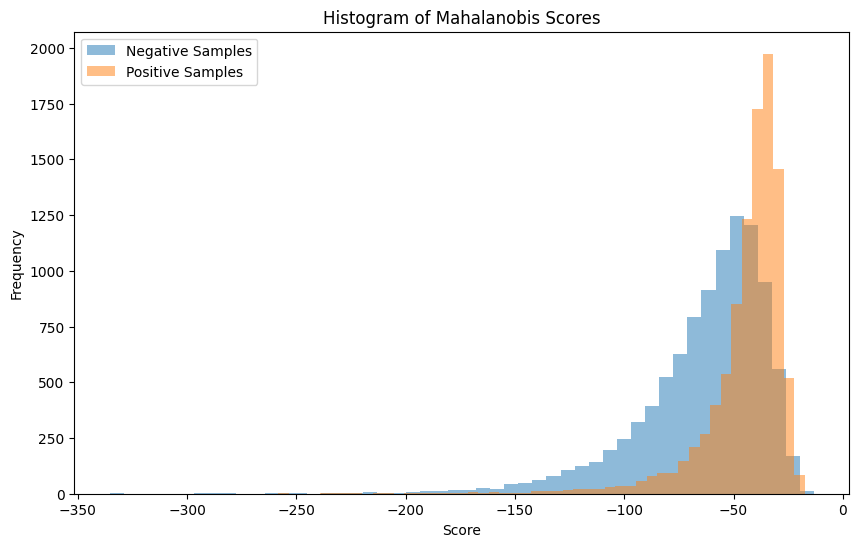

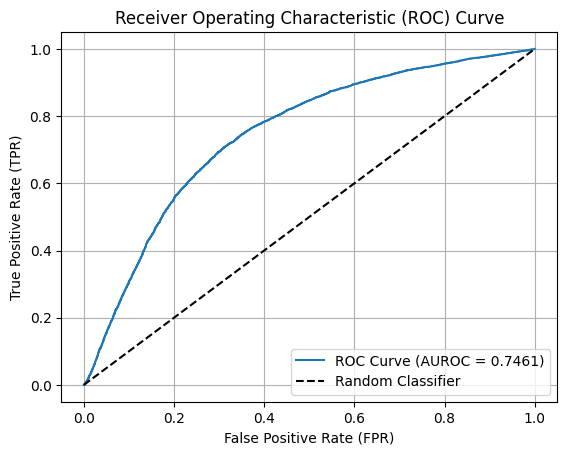

In [128]:
metrics_dict['Mahalanobis'] = {}

maha = Mahalanobis()
maha.fit(train_features, cifar_train.targets)

scores_negatives = maha.compute_scores(test_features_negatives)
scores_positives = maha.compute_scores(test_features_positives)

# Plot the histogram of the scores
plt.figure(figsize=(10, 6))
plt.hist(scores_negatives, bins=50, alpha=0.5, label='Negative Samples')
plt.hist(scores_positives, bins=50, alpha=0.5, label='Positive Samples')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title(f'Histogram of Mahalanobis Scores')
plt.legend()
plt.show()

auroc = roc_auc(scores_negatives, scores_positives)
metrics_dict['Mahalanobis']['auroc'] = auroc

In [129]:
threshold = compute_threshold(scores_positives, target_tpr)

metrics_dict['Mahalanobis']['accuray'] = accuracy(scores_negatives, scores_positives, threshold)
metrics_dict['Mahalanobis']['tpr'], metrics_dict['Mahalanobis']['fpr'] = tpr_fpr(scores_negatives, scores_positives, threshold)
metrics_dict['Mahalanobis']['precision'], metrics_dict['Mahalanobis']['recall'] = precision_recall(scores_negatives, scores_positives, threshold)
metrics_dict['Mahalanobis']['f1'] = f_beta(scores_negatives, scores_positives, threshold, beta=1)

## Results Table
**Exercise.** Plot the results stored in the dictionary `metrics_dict` by highlighting the method that achieves the best value for each of the different metrics.

In [130]:
import pandas as pd

metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index')

def highlight_extreme(s):
    # Check if the column is "fpr"
    if s.name == "fpr":
        # Highlight the minimum value
        is_extreme = s == s.min()
    else:
        # Highlight the maximum value
        is_extreme = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_extreme]

# Apply the function to the DataFrame
styled_df = metrics_df.style.apply(highlight_extreme, axis=0)

styled_df

,auroc,accuray,tpr,fpr,precision,recall,f1
MLS,0.848671,0.797900,0.900000,0.304200,0.747384,0.900000,0.816623
MSP,0.834972,0.770500,0.900000,0.359000,0.714853,0.900000,0.796813
Energy,0.835966,0.794050,0.900000,0.311900,0.742636,0.900000,0.813780
Entropy,0.849425,0.792450,0.900000,0.315100,0.740680,0.900000,0.812604
DKNN,0.632202,0.608950,0.900000,0.682100,0.568864,0.900000,0.697107
Mahalanobis,0.746129,0.643500,0.900000,0.613000,0.594845,0.900000,0.716275


**Bonus Exercises.** If you still have time, you can try and do the following:
1. Play with different temperature parameters in the *Energy* score to see how they affect the different metrics.
2. Play with different $k$ parameters in the *DKNN* algorithm to see how they affect the different metrics.
3. Write docstirngs for the above function (In the future, you will be greatful to your current self if you find yourself checking out this notebook and the docstrings are there).
4. Download a better model (e.g. a pre-trained VGG model fine-tuned on Cifar-10) and check out if you get better results with it.
5. Check out the OODEEL library where a benchmark like the one we have just carried-out is much easier to perform ;)